In [ ]:
from paretoset import paretoset
import pandas as pd 
import numpy as np
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib
import copy
from utils import *

## Settings and configurations

In [3]:
# benchmarks = {
#             "transcode": ["cats-1", "video-1", "video-2", "video-3", "video-4", "video-5", "video-6", "video-7", "video-8", "video-9", "video-10"], 
#             "pigo-faceblur": ["faces2", "image-1", "image-2", "image-3", "image-4", "image-5", "image-6", "image-7", "image-8", "image-9", "image-10"], 
#             "pigo-face-detector": ["faces2", "image-1", "image-2", "image-3", "image-4", "image-5", "image-6", "image-7", "image-8", "image-9", "image-10"], 
#             "openfaas-ocr": ["doc", "image-1", "image-2", "image-3", "image-4", "image-5", "image-6", "image-7", "image-8", "image-9", "image-10"], 
#             "linpack": ["2500", "1000", "5000", "7500"],
#             "s3": ["cats-1", "video-1", "video-2", "video-3", "video-4", "video-5", "video-6", "video-7", "video-8", "video-9", "video-10"]
#             }

benchmarks = {
            "transcode": ["cats-1", "video-1", "video-2", "video-3", "video-4", "video-5"], 
            "pigo-faceblur": ["faces2", "image-1", "image-2", "image-3", "image-4", "image-5"], 
            "pigo-face-detector": ["faces2", "image-1", "image-2", "image-3", "image-4", "image-5"], 
            "openfaas-ocr": ["doc", "image-1", "image-2", "image-3", "image-4", "image-5"], 
            "linpack": ["2500", "1000", "5000", "7500"],
            "s3": ["cats-1", "video-1", "video-2", "video-3", "video-4", "video-5"]
            }

benchmark_naming = {"transcode": "transcode", "pigo-faceblur": "faceblur", "pigo-face-detector": "facedetect", "classifier": "classifier", "linpack": "linpack", "s3": "s3", "openfaas-ocr": "ocr"}

# benchmarks ={"classifier": "bridge-8k-1920x1200"}
base_estimator = 'GP'
CPU_LIMITS= [ '250m', '500m', '750m', '1000m', '1250m', '1500m', '1750m', '2000m' ]
MEMORY_LIMITS=[ '128Mi', '256Mi', '512Mi', '768Mi', '1024Mi', '2048Mi' ]
instance_types = ['m5', 'm5a', 'c5', 'c5a', 'c6g', 'm6g']

N_TRAILS = 20
N_INIT_SAMPLES = 3
N_OPT_TRAILS = 10

data_dir = 'analysis_data/'

calculate_cpu_mem_costs()

## Helper function to train model

In [7]:
def train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='runtime'):
    if base_estimator != "poly":
        from optimizer.boskopt import Models
        model = Models()
        model.create_model(function=function_name, base_estimator=base_estimator)
    else:
        from optimizer.polyreg import Models
        model = Models()
        model.create_model(function=function_name)

    runtimes = []
    costs = []

    minimum = 600.0
    best_config = {}

    init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
    # init_samples = get_init_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES, var=True)

    default_config = init_samples[0]
    config = default_config
    # print(config)

    if base_estimator != "poly":
        from optimizer.boskopt import Models
        model = Models()
        model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
    else:
        from optimizer.polyreg import Models
        model = Models()
        model.create_model(function=function_name)

    for i in range(0, N_TRAILS):
        success = True

        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        runtimes.append(result)

        if result < minimum:
            minimum = result
            best_config = config 
        # print(result, config)

        model.update(config, result, function_name, success=True)
        
        if i < N_INIT_SAMPLES-1:
            config = init_samples[i+1]
        else:
            config = model.get_next_config(function_name)
        
    return model, best_config 

## Performance model across data
This part of the notebook creates two scenarios:
1. One performance model to predict the performance of all input data (trained using the default data)
2. One performance model for each input (trained for that input)
and compares their performance

In [ ]:
for function_name in benchmarks.keys():
    print(function_name)
    comparing_performance = pd.DataFrame(columns=['benchmark', 'data name', 'performance', 'config'])


    for x in range(0, N_OPT_TRAILS):
        data_name = benchmarks[function_name][0]
        print(x)
        runtimes = []
        costs = []

        minimum = 600.0
        config_base_model = {}

        init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
        # init_samples = get_init_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES, var=True)

        default_config = init_samples[0]
        config = default_config
        # print(config)

        if base_estimator != "poly":
            from optimizer.boskopt import Models
            base_model = Models()
            base_model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
        else:
            from optimizer.polyreg import Models
            base_model = Models()
            base_model.create_model(function=function_name)

        for i in range(0, N_TRAILS):
            success = True

            result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS)
            runtimes.append(result)

            if result < minimum:
                # print(result, config, data_name)
                minimum = result
                config_base_model = copy.copy(config) 

            base_model.update(config, result, function_name, success=True)
            
            if i < N_INIT_SAMPLES-1:
                config = init_samples[i+1]
            else:
                config = base_model.get_next_config(function_name)

        # best_configs = base_model.get_top_across_types(function_name, marker='all')
        # print(best_config)
        # config = best_configs[0][1]
        # config_base_model = {'instance_type': config[0], 'cpu': config[1], 'memory': config[2]}
        # print(config_base_model)

        for data_name in benchmarks[function_name][1:]:
            # print(data_name)
            model, best_config = train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name)
            # best_configs = model.get_top_across_types(function_name, marker='all')
            # print(best_configs)
            # config = best_configs[0][1]
            # config = {'instance_type': config[0], 'cpu': config[1], 'memory': config[2]}
            # print(config)

            result_base_model = get_result_from_data(function_name, data_name, config_base_model, MEMORY_LIMITS)
            result_spec_model = get_result_from_data(function_name, data_name, best_config, MEMORY_LIMITS)
            actual_best = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='runtime')

            # print(result_base_model, result_spec_model, actual_best)

            comparing_performance = comparing_performance.append({'benchmark': function_name, 'data name': data_name, 'performance': result_base_model, 'config': 'Single model-based'}, ignore_index=True)
            comparing_performance = comparing_performance.append({'benchmark': function_name, 'data name': data_name, 'performance': result_spec_model, 'config': 'Specific model-based'}, ignore_index=True)
            comparing_performance = comparing_performance.append({'benchmark': function_name, 'data name': data_name, 'performance': actual_best[0], 'config': 'Best'}, ignore_index=True)

    comparing_performance.to_csv(data_dir + function_name +'-data-dependent.csv', index=False)

# For execution time objective

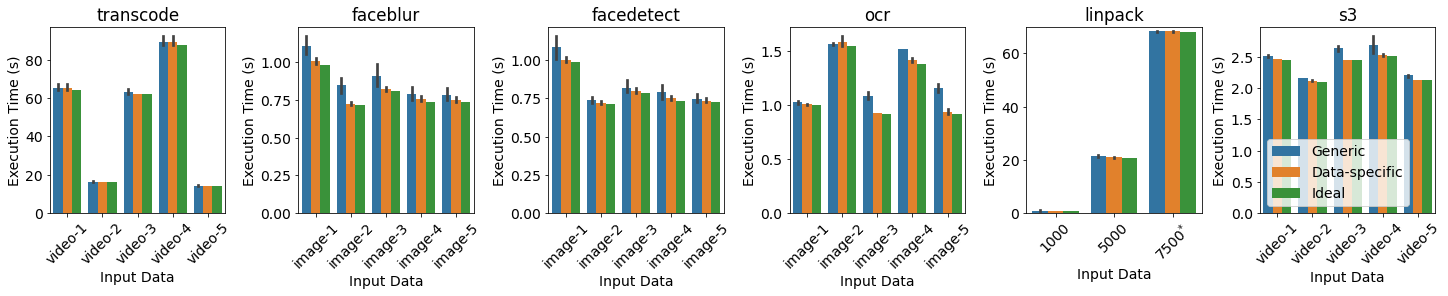

In [13]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=6, constrained_layout=True)
j = 0
matplotlib.rcParams.update({'font.size': 14})
for function_name in benchmarks.keys():

    comparing_performance = pd.read_csv(data_dir + function_name +'-data-dependent.csv')
    comparing_performance = comparing_performance[comparing_performance['data name'].isin(benchmarks[function_name])]
    comparing_performance.replace({'Single model-based': 'Generic', 'Specific model-based': 'Data-specific', 'Best': 'Ideal'}, inplace=True)

    if function_name == 'linpack':
        comparing_performance.drop(comparing_performance[comparing_performance['performance']==10000.0].index, inplace=True)
        # print(comparing_performance)
        # print(comparing_performance[comparing_performance['data name']==7500])
        comparing_performance.replace({7500: '$7500^{*}$'}, inplace=True)


    # comparing_performance.replace({10000.0: 'bridge'}, inplace=True)
    ax = sns.barplot(data=comparing_performance, x='data name', y='performance', hue='config', ax=axs[j])

    j += 1
    # ax.axhline(minimum_runtime, ls='--')
    # # ax.text(0.5,minimum_runtime+10, "Minimum")m
    # ax.set_xticks(np.arange(0, 22, 2))
    if function_name == "linpack":
        ax.set_ylim((0, 70))
    ax.set_title(benchmark_naming[function_name])
    ax.set_ylabel("Execution Time (s)")
    ax.set_xlabel("Input Data")
    # plt.show()
    # plt.xticks(rotation=45)
    ax.tick_params(axis='x', rotation=45)
    
    # if j != 5:
    ax.legend().set_visible(False)

plt.legend(ncol=1, loc='lower left')
plt.savefig('plots/opt_across_data.pdf', bbox_inches = "tight")

# For execution cost objective

In [ ]:
for function_name in benchmarks.keys():
    print(function_name)
    comparing_performance = pd.DataFrame(columns=['benchmark', 'data name', 'performance', 'config'])


    
    for x in range(0, N_OPT_TRAILS):
        data_name = benchmarks[function_name][0]
        runtimes = []
        costs = []

        minimum = 600.0

        init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
        # init_samples = get_init_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES, var=True)

        default_config = init_samples[0]
        config = default_config
        # print(config)

        if base_estimator != "poly":
            from optimizer.boskopt import Models
            base_model = Models()
            base_model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
        else:
            from optimizer.polyreg import Models
            base_model = Models()
            base_model.create_model(function=function_name)

        for i in range(0, N_TRAILS):
            success = True

            result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='cost')
            runtimes.append(result)

            base_model.update(config, result, function_name, success=True)
            
            if i < N_INIT_SAMPLES-1:
                config = init_samples[i+1]
            else:
                config = base_model.get_next_config(function_name)

    best_configs = base_model.get_top_across_types(function_name, marker='all')
    # print(best_configs)
    config = best_configs[0][1]
    config_base_model = {'instance_type': config[0], 'cpu': config[1], 'memory': config[2]}

    for data_name in benchmarks[function_name][1:]:
        print(data_name)
        model, _ = train_model(N_OPT_TRAILS, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='cost')
        best_configs = model.get_top_across_types(function_name, marker='all')
        # print(best_configs)
        config = best_configs[0][1]
        config = {'instance_type': config[0], 'cpu': config[1], 'memory': config[2]}
        print(config)

        result_base_model = get_result_from_data(function_name, data_name, config_base_model, MEMORY_LIMITS, metric='cost')
        result_spec_model = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='cost')
        actual_best = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='cost')

        # print(result_base_model, result_spec_model, actual_best)

        comparing_performance = comparing_performance.append({'benchmark': function_name, 'data name': data_name, 'performance': result_base_model, 'config': 'Single model-based'}, ignore_index=True)
        comparing_performance = comparing_performance.append({'benchmark': function_name, 'data name': data_name, 'performance': result_spec_model, 'config': 'Specific model-based'}, ignore_index=True)
        comparing_performance = comparing_performance.append({'benchmark': function_name, 'data name': data_name, 'performance': actual_best[0], 'config': 'Best'}, ignore_index=True)

    comparing_performance.to_csv(data_dir + function_name +'-ec-data-dependent.csv', index=False)

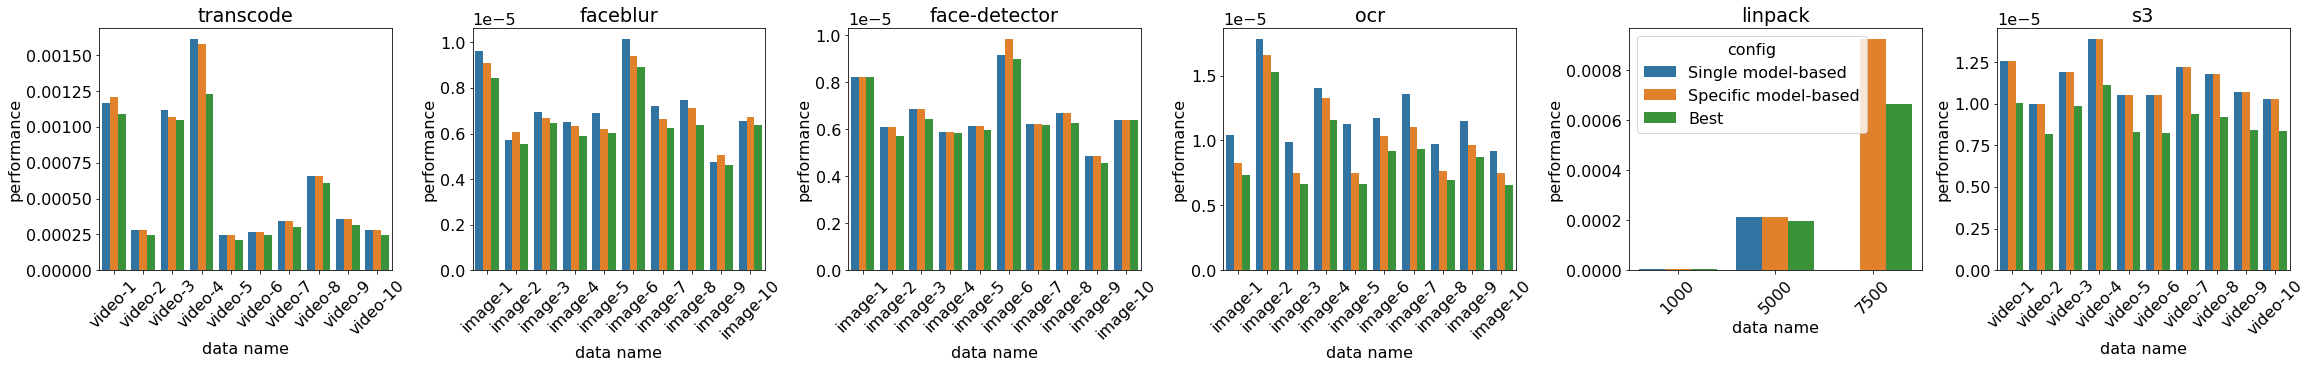

In [22]:
fig, axs = plt.subplots(figsize=(32, 5), ncols=6, constrained_layout=True)
j = 0
matplotlib.rcParams.update({'font.size': 16})
for function_name in benchmarks.keys():

    comparing_performance = pd.read_csv(data_dir + function_name +'-ec-data-dependent.csv')
    ax = sns.barplot(data=comparing_performance, x='data name', y='performance', hue='config', ax=axs[j])

    j += 1
    # ax.axhline(minimum_runtime, ls='--')
    # # ax.text(0.5,minimum_runtime+10, "Minimum")m
    # ax.set_xticks(np.arange(0, 22, 2))
    # ax.set_ylim((minimum_runtime * 0.9, minimum_runtime*1.5))
    ax.set_title(benchmark_naming[function_name])
    ax.set_ylabel("Execution Cost ($)")
    # plt.show()
    # plt.xticks(rotation=45)
    ax.tick_params(axis='x', rotation=45)
    
    if j != 5:
        ax.legend().set_visible(False)
    
plt.savefig('plots/opt_across_data-ec.pdf', bbox_inches = "tight")